In [ ]:
import pandas as pd
import numpy as np
from datetime import date
import re
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_log_error

In [ ]:
sales=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/RNN/sales_2018-01-01_2022-10-10.csv')
day_visits = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/RNN/day_visit_data.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#Function to remove outliers
cols = ['col_1', 'col_2'] # one or more
def outlier_remove(df,cols):
  Q1 = df[cols].quantile(0.1)
  Q3 = df[cols].quantile(0.90)
  IQR = Q3 - Q1

  df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
  return df

In [ ]:
def series_replace(ser,arr,regexp):
  new_ser=np.array([])
  for x in ser:
    if x in arr:
      exp=re.findall(regexp,x)
      new_ser=np.append(new_ser,exp[0]) 
    else:
      new_ser=np.append(new_ser,x) 
  return new_ser

In [ ]:
def fill_dates_nr(variants,group):
  x=variants.get_group(group)
  if group in discontinued:
    return x
  if group in discontinuing:
    return x
  day=pd.date_range(x.day.min(), x.day.max(), freq='1D')
  day=[i for i in day if i not in x['day']]
  dates=pd.DataFrame({'day':day})
  dates['net_quantity']=0
  dates['variant_sku']=group
  newdf=pd.concat([dates,x])
  newdf=newdf.sort_values('day')
  newdf['product_price']=newdf['product_price'].fillna(method='ffill')
  newdf['product_price']=newdf['product_price'].fillna(method='bfill')
  #newdf['net_sales'].fillna(x['product_price'].mode()[0],inplace=True)
  return newdf

In [ ]:
#Discount dates
def disc_date(df,var,text,start,end=False):
  if var!='all':
    if not isinstance(var,list):
      var=[var]
  if not end:
    end=date.today()
  dates=pd.date_range(start,end)
  #match dates
  mask1=df['day'].isin(dates)
  #match variants
  if var=='all':
    mask2=[True]*len(df)
  else:
    mask2=[False]*len(df)
    for i in var:
      mask2=mask2 | df['variant_sku'].str.contains(i)
  if text in df.columns:
    df[text+'1']=(mask1*mask2)
    df[text]=df[text]+df[text+'1']
    df.drop(columns=text+'1')
  else:
    df[text]=(mask1 * mask2)
  return df

In [ ]:
def data_prep(sales):
  #Sales only for NA
  NA_sales=sales.loc[sales['shipping_country'].isin(['United States'])]
  NA_sales.drop(columns='shipping_country',inplace=True)
  #scooters only
  NA_scooter=NA_sales[NA_sales['product_type'].isin(['scooter','Light Scooter','electric scooter'])]
  #Only some vendors (EMOVE, Kaabo, Dualtron, Fiido)
  scooter_sales=NA_scooter.loc[NA_scooter['product_vendor'].isin(['EMOVE', 'Kaabo', 'Dualtron', 'FIIDO'])]
  #Change day to datetime
  scooter_sales['day']=pd.to_datetime(scooter_sales['day'])
  #Don't use 2018 data
  scooter_sales=scooter_sales.loc[scooter_sales['day'].dt.year>2018]
  #Set day as index
  scooter_sales.set_index('day',inplace=True)
  return scooter_sales.dropna()

In [ ]:
def title_clean(scooter_sales):
  #capitalize all product title
  scooter_sales['product_title']=scooter_sales['product_title'].str.upper()
  #Remove String inconsistencies in product_title
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace('(?<=EMOVE CRUISER).*$','')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace('(?<=EMOVE TOURING).*$','')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace('(?<=EMOVE 2.0).*$','')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace('(?<=WOLF KING GT).*$','')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace('(?<=WOLF WARRIOR GT).*$','')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace('KAABO\s','')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace('\.','')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace("\s\|.*",'')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace("(X2)\sUP",'X2')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace(r"FIIDO(.*)SEATED",'FIIDO SEATED')
  #remove refurbished
  stock_sales=scooter_sales.loc[~scooter_sales['product_title'].str.match('REFURBISHED')]
  return stock_sales

In [ ]:
def variant_clean(stock_sales):
  #Fix Variant
  #Remove unknown digits
  stock_sales['variant_sku']=stock_sales['variant_sku'].str.replace('-\d+-','-')
  #Remove Early string and dashes
  stock_sales['variant_sku']=stock_sales['variant_sku'].str.replace('[eE]arly\-+','')
  #Remove -new string
  stock_sales['variant_sku']=stock_sales['variant_sku'].str.replace('-[nN]ew','')
  #add color to mantis king with no color
  stock_sales['variant_sku']=stock_sales['variant_sku'].str.replace('^Kaabo-Mantis-King-GT$','Kaabo-Mantis-King-GT-Black')
  #replace discontinued FIIDO
  stock_sales['variant_sku']=series_replace(stock_sales['variant_sku'],['FIIDO-Q1s-Red','FIIDO-Q1s-White','FIIDO-Q1-Green','FIIDO-Q1-Red','FIIDO-Q1-White'],'\w+\-\w+')
  #Remove 2022
  stock_sales['variant_sku']=stock_sales['variant_sku'].str.replace('2022\-','')
  stock_sales['variant_sku']=stock_sales['variant_sku'].str.replace('[kK]ing-[sS]treet','king')
  #remove touring green
  stock_sales=stock_sales.loc[stock_sales['variant_sku']!='touring-green']
  #Capitalize 
  stock_sales['variant_sku']=stock_sales['variant_sku'].str.upper()
  #Remove random emove
  stock_sales=stock_sales.loc[~(stock_sales['variant_sku'].isin(['EMOVE-BLACK','EMOVE-GREEN','EMOVE-ORANGE','EMOVE-WHITE','FIIDO-Q1','FIIDO-Q1S']))]
  stock_sales.dropna(inplace=True)
  return stock_sales

In [ ]:
def data_clean(stock_sales):
  #remove negative orders
  stock_sales=stock_sales[stock_sales['net_quantity']>=1]
  #Drop columns that won't be used
  new_df=stock_sales.drop(columns=['product_title','product_type']).reset_index()
  #discounts divide by order
  new_df['discounts']=new_df['discounts']/new_df['net_quantity']
  #Remove discounts that are too high
  new_df['disc_per']=np.abs(new_df['discounts']/new_df['product_price'])
  new_df=new_df[new_df['disc_per']<=0.08]
  new_df.drop(columns='disc_per',inplace=True)
  return new_df[['day','product_vendor','variant_sku','product_price','net_quantity']]

In [ ]:
scooter_sales=data_prep(sales)
stock_sales=title_clean(scooter_sales)
stock_sales=variant_clean(stock_sales)
new_df=data_clean(stock_sales)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will chan

In [ ]:
discontinued=['wolf-warrior-x-black-street','wolf-warrior-base-black-street','wolf-warrior-x-gold-street','Wolf-Warrior-Street-Tires','Wolf-Warrior-Off-Road-Tires','dualtron-thunder-tronic']
discontinued=[i.upper() for i in discontinued]

In [ ]:
discontinuing=['dualtron-x2','dualtron-thunder','dualtron-mini','dualtron-storm']
discontinuing=[i.upper() for i in discontinuing]

In [ ]:
#Separate dataframe to different variants
variants=new_df.groupby('variant_sku')

In [ ]:
df=pd.DataFrame()
for i in variants.groups.keys():
  df=pd.concat([df,fill_dates_nr(variants,i)])

In [ ]:
df=df.groupby([col for col in df.columns if col!='net_quantity']).sum().reset_index()
df.sort_values(by=['variant_sku','day'],axis=0,inplace=True)

In [ ]:
discontinued=['wolf-warrior-x-black-street','wolf-warrior-base-black-street','wolf-warrior-x-gold-street','Wolf-Warrior-Street-Tires','Wolf-Warrior-Off-Road-Tires','dualtron-thunder-tronic']
discontinued=[i.upper() for i in discontinued]

In [ ]:
#Separate dataframe to different variants
variants=new_df.groupby('variant_sku')

print(variants)

In [ ]:
df=pd.DataFrame()
for i in variants.groups.keys():
  df=pd.concat([df,fill_dates_nr(variants,i)])

print(df)

            day  net_quantity                    variant_sku product_vendor  \
0    2021-08-27             0  BLACK-KAABO-OFFROAD-WOLF-KING            NaN   
6837 2021-08-27             1  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo   
1    2021-08-28             0  BLACK-KAABO-OFFROAD-WOLF-KING            NaN   
2    2021-08-29             0  BLACK-KAABO-OFFROAD-WOLF-KING            NaN   
7120 2021-08-30             3  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo   
...         ...           ...                            ...            ...   
7847 2022-06-28             2    WOLF-WARRIOR-X-BLACK-STREET          Kaabo   
7848 2022-06-13             1    WOLF-WARRIOR-X-BLACK-STREET          Kaabo   
7841 2022-08-19             1     WOLF-WARRIOR-X-GOLD-STREET          Kaabo   
7842 2022-08-28             1     WOLF-WARRIOR-X-GOLD-STREET          Kaabo   
7844 2022-06-28             1     WOLF-WARRIOR-X-GOLD-STREET          Kaabo   

      product_price  
0            2999.0  
6837   

In [ ]:
df=df.groupby([col for col in df.columns if col!='net_quantity']).sum().reset_index()
df.sort_values(by=['variant_sku','day'],axis=0,inplace=True)

print(df)

            day                    variant_sku product_vendor  product_price  \
3139 2021-08-27  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3169 2021-08-30  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3180 2021-08-31  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3255 2021-09-09  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3283 2021-09-11  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
...         ...                            ...            ...            ...   
5857 2022-06-28    WOLF-WARRIOR-X-BLACK-STREET          Kaabo         2395.0   
5905 2022-07-03    WOLF-WARRIOR-X-BLACK-STREET          Kaabo         2395.0   
5858 2022-06-28     WOLF-WARRIOR-X-GOLD-STREET          Kaabo         2295.0   
6356 2022-08-19     WOLF-WARRIOR-X-GOLD-STREET          Kaabo         2295.0   
6432 2022-08-28     WOLF-WARRIOR-X-GOLD-STREET          Kaabo         2295.0   

      net_quantity  
3139             1

In [ ]:
discontinued=['wolf-warrior-x-black-street','wolf-warrior-base-black-street','wolf-warrior-x-gold-street','Wolf-Warrior-Street-Tires','Wolf-Warrior-Off-Road-Tires','dualtron-thunder-tronic']
discontinued=[i.upper() for i in discontinued]

In [ ]:
discontinuing=['dualtron-x2','dualtron-thunder','dualtron-mini','dualtron-storm']
discontinuing=[i.upper() for i in discontinuing]

In [ ]:
df=df[~df['variant_sku'].isin(discontinued)]
df=df[~df['variant_sku'].isin(discontinuing)]

In [ ]:
print(df)

            day                    variant_sku product_vendor  product_price  \
3139 2021-08-27  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3169 2021-08-30  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3180 2021-08-31  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3255 2021-09-09  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3283 2021-09-11  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
...         ...                            ...            ...            ...   
6700 2022-10-01               WKGT-GOLD-STREET          Kaabo         3595.0   
6704 2022-10-02               WKGT-GOLD-STREET          Kaabo         3595.0   
6725 2022-10-05               WKGT-GOLD-STREET          Kaabo         3595.0   
6739 2022-10-07               WKGT-GOLD-STREET          Kaabo         3595.0   
6754 2022-10-10               WKGT-GOLD-STREET          Kaabo         3595.0   

      net_quantity  
3139             1

In [ ]:
temp = df.groupby('variant_sku')
for i in temp.groups.keys():
  print(i)

BLACK-KAABO-OFFROAD-WOLF-KING
BLACK-KAABO-WOLF-KING
CRUISER-BLACK
CRUISER-BLUE
CRUISER-ORANGE
CRUISER-PURPLE
CRUISER-RED
CRUISER-WHITE
CRUISER-YELLOW
DUALTRON-ACHILLEUS
DUALTRON-CITY
DUALTRON-EAGLE-PRO
DUALTRON-SPIDER-2
DUALTRON-STORM-LIMITED
DUALTRON-THUNDER2
DUALTRON-ULTRA-2
DUALTRON-VICTOR
DUALTRON-VICTOR-LUXURY
DUALTRON-X-LIMITED
EMOVE-ROADRUNNER
EMOVE-ROADRUNNER-TRONIC
FIIDO-Q1-BLACK
FIIDO-Q1S-BLACK
FIIDO-Q1S-GREEN
GOLD-KAABO-OFFROAD-WOLF-KING
GOLD-KAABO-WOLF-KING
KAABO-MANTIS-KING-GT-BLACK
KAABO-MANTIS-KING-GT-GOLD
KAABO-MANTISPRO-BLACK-18.2AH
KAABO-MANTISPRO-BLACK-24AH
KAABO-MANTISPRO-GOLD
KAABO-MANTISPRO-GOLD-18.2AH
KAABO-MANTISPRO-GOLD-24AH
KAABO-OFFROAD-WOLF-KING
KAABO-WOLF-KING
KAABO-WOLF-WARRIOR-GT-OFF-ROAD
KAABO-WOLF-WARRIOR-GT-STREET
KAABO-WOLF-WARRIOR-X-GT-BLACK
KAABO-WOLF-WARRIOR-X-GT-GOLD
TOURING-BLACK
TOURING-ORANGE
TOURING-PURPLE
TOURING-RED
TOURING-WHITE
WKGT-BLACK-OFFROAD
WKGT-BLACK-STREET
WKGT-GOLD-OFFROAD
WKGT-GOLD-RACING
WKGT-GOLD-STREET


In [ ]:
# print(day_visits)
# day_visits = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/RNN/day_visit_data.csv')
# temp = day_visits.groupby('page_path')
# for i in temp.groups.keys():
#   print(i)

In [ ]:
day_visits = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/RNN/day_visit_data.csv')

def path_clean(day_visits):
  visits_arr = np.array(day_visits)
  for i in range(len(visits_arr)):
    temp = visits_arr[i][1]
    try:
      visits_arr[i][1] = temp.split("/")[-1].upper()
      # a/b/c -> ['a', 'b', 'c']
    except:
      print(f'{temp} 값 버림')
      # print(temp)

  day_visits = pd.DataFrame(visits_arr, columns=np.array(['page_type', 'page_path', 'day', 'total_visitor', 'total_sessions', 'total_carts', 'total_checkouts']))

  return day_visits

day_visits = path_clean(day_visits)
print(day_visits)

nan 값 버림
nan 값 버림
nan 값 버림
nan 값 버림
nan 값 버림
       page_type                                  page_path         day  \
0        Product                              EMOVE-CRUISER  2020-09-11   
1        Product                              EMOVE-CRUISER  2019-12-02   
2        Product                              EMOVE-CRUISER  2020-09-13   
3        Product                              EMOVE-CRUISER  2020-08-13   
4        Product                              EMOVE-CRUISER  2020-09-12   
...          ...                                        ...         ...   
114345   Product                        VM-FULL-FACE-HELMET  2022-08-26   
114346   Product  CHARGING-PORT-COVER-FOR-THE-MANTIS-PRO-SE  2022-04-26   
114347   Product                        VM-FULL-FACE-HELMET  2022-06-15   
114348   Product  CHARGING-PORT-COVER-FOR-THE-MANTIS-PRO-SE  2022-09-04   
114349   Product                        VM-FULL-FACE-HELMET  2022-05-04   

       total_visitor total_sessions total_carts total_

In [ ]:
day_visits

,page_type,page_path,day,total_visitor,total_sessions,total_carts,total_checkouts
0,Product,EMOVE-CRUISER,2020-09-11,3498,3576,27,6
1,Product,EMOVE-CRUISER,2019-12-02,3260,3343,33,6
2,Product,EMOVE-CRUISER,2020-09-13,2587,2664,35,13
3,Product,EMOVE-CRUISER,2020-08-13,2398,2588,102,45
4,Product,EMOVE-CRUISER,2020-09-12,2500,2569,31,15
...,...,...,...,...,...,...,...
114345,Product,VM-FULL-FACE-HELMET,2022-08-26,1,1,0,0
114346,Product,CHARGING-PORT-COVER-FOR-THE-MANTIS-PRO-SE,2022-04-26,1,1,0,0
114347,Product,VM-FULL-FACE-HELMET,2022-06-15,1,1,0,0
114348,Product,CHARGING-PORT-COVER-FOR-THE-MANTIS-PRO-SE,2022-09-04,1,1,0,0


In [ ]:
sample = day_visits[day_visits['page_path']=='EMOVE-CRUISER']
sample = sample.sort_values(by=['day'])
sample

,page_type,page_path,day,total_visitor,total_sessions,total_carts,total_checkouts
1779,Product,EMOVE-CRUISER,2019-11-24,313,338,7,4
1446,Product,EMOVE-CRUISER,2019-11-25,403,438,14,6
261,Product,EMOVE-CRUISER,2019-11-26,821,884,34,8
774,Product,EMOVE-CRUISER,2019-11-27,648,695,14,7
352,Product,EMOVE-CRUISER,2019-11-28,790,839,20,6
...,...,...,...,...,...,...,...
593,Product,EMOVE-CRUISER,2022-10-20,712,753,20,16
16733,Product,EMOVE-CRUISER,2022-10-20,9,9,0,0
9998,Product,EMOVE-CRUISER,2022-10-20,25,26,1,0
699,Product,EMOVE-CRUISER,2022-10-21,664,720,21,12


In [ ]:
temp_date_df  = pd.DataFrame(pd.date_range(np.array(sample)[0][2], np.array(sample)[-1][2]), columns={'day'})
print(temp_date_df)
temp_date_df.day=temp_date_df.day.astype(str)

# 같은 날은 그대로 두고 없는 날짜만 추가.
new_df = pd.merge(sample, temp_date_df, how='outer')
print(new_df)

new_df = new_df.sort_values(by=['day'])

dup = np.array(new_df.duplicated(['day']))
new_df_arr = np.array(new_df)

for i in range(len(new_df_arr)):
  if dup[i] == True:
    print(f'---------------------------------------------------------------------')
    print(f'중복1 : {new_df_arr[i-1]}') ---> temp
    print(f'중복2 : {new_df_arr[i]}') 
    # temp = new_df_arr[i][-1]
    new_df_arr[i][3] = new_df_arr[i-1][3] + new_df_arr[i][3]
    new_df_arr[i][4] = new_df_arr[i-1][4] + new_df_arr[i][4]
    new_df_arr[i][5] = new_df_arr[i-1][5] + new_df_arr[i][5]
    new_df_arr[i][6] = new_df_arr[i-1][6] + new_df_arr[i][6]

    print(f'중복합친후 : {new_df_arr[i]}')
    print('---------------------------------------------------------------------')


new_df = pd.DataFrame(new_df_arr, columns=new_df.columns)
new_df.drop_duplicates(['day'], keep='last', inplace=True)

# 'total_visitor', 'total_sessions', 'total_carts', 'total_checkouts'
sample_visitor = new_df['total_visitor']
sample_sessions = new_df['total_sessions']
sample_carts = new_df['total_carts']
sample_checkouts = new_df['total_checkouts']

sample_visitor.index = new_df['day']
sample_visitor = sample_visitor.fillna(0)

sample_sessions.index = new_df['day']
sample_sessions = sample_sessions.fillna(0)

sample_carts.index = new_df['day']
sample_carts = sample_carts.fillna(0)

sample_checkouts.index = new_df['day']
sample_checkouts = sample_checkouts.fillna(0)

            day
0    2019-11-24
1    2019-11-25
2    2019-11-26
3    2019-11-27
4    2019-11-28
...         ...
1059 2022-10-18
1060 2022-10-19
1061 2022-10-20
1062 2022-10-21
1063 2022-10-22

[1064 rows x 1 columns]
     page_type      page_path         day total_visitor total_sessions  \
0      Product  EMOVE-CRUISER  2019-11-24           313            338   
1      Product  EMOVE-CRUISER  2019-11-25           403            438   
2      Product  EMOVE-CRUISER  2019-11-26           821            884   
3      Product  EMOVE-CRUISER  2019-11-27           648            695   
4      Product  EMOVE-CRUISER  2019-11-28           790            839   
...        ...            ...         ...           ...            ...   
1552   Product  EMOVE-CRUISER  2022-10-20           712            753   
1553   Product  EMOVE-CRUISER  2022-10-20             9              9   
1554   Product  EMOVE-CRUISER  2022-10-20            25             26   
1555   Product  EMOVE-CRUISER  2022-10-21  

In [ ]:
sample_visitor.to_csv('/content/drive/MyDrive/ColabNotebooks/RNN/sample_visitor.csv')
sample_sessions.to_csv('/content/drive/MyDrive/ColabNotebooks/RNN/sample_sessions.csv')
sample_carts.to_csv('/content/drive/MyDrive/ColabNotebooks/RNN/sample_carts.csv')
sample_checkouts.to_csv('/content/drive/MyDrive/ColabNotebooks/RNN/sample_checkouts.csv')

In [ ]:
def split_data(dataset, sc):
  print(len(dataset))
  train_sc_df = dataset[:-50] #150
  print(len(train_sc_df))
  test_sc_df = dataset[len(train_sc_df):] #50
  print(len(test_sc_df))

  # standardization
  
  train_sc = np.array(train_sc_df).reshape((-1,1))
  train_sc = sc.fit_transform(train_sc)
  train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train_sc_df.index)
  train_sc_df.to_csv('./train_sc.csv')
  print("------------train_sc_df--------------")
  print(train_sc_df.head())
  train_index_df = train_sc_df

  test_sc = np.array(test_sc_df).reshape((-1,1))
  test_sc = sc.transform(test_sc)
  test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test_sc_df.index)
  print("------------test_sc_df--------------")
  print(test_sc_df.head())
  test_sc_df.to_csv('./test_sc.csv')

  test_index_df = test_sc_df

  """
  Shift는 이전 정보를 row에서 다시 쓰기 위한 pandas의 함수
  이를통해 과거의 값들을 shift_s와 같은 형태로 저장할 수 있다.
  과거 값은 총 12개를 저장하면, timestep은 12개가 된다.
  우리의 목적은 과거값 shift 1~8 (일주일의 자료)를 통해 형재값 scaled를 예측하는 것이다.
  """
  for s in range(1, 8):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

  print("------------shifted train_sc_df--------------")
  print(train_sc_df.head(8))

  print("------------shifted test_sc_df--------------")
  print(test_sc_df.head(8))

  """
  NaN값은 제거하고, shift_1 ~ shift_7은 X로 Scaled는 Y로 지정
  """
  X_train = train_sc_df.dropna().drop('Scaled', axis=1)
  y_train = train_sc_df.dropna()[['Scaled']]

  X_test = test_sc_df.dropna().drop('Scaled', axis=1)
  y_test = test_sc_df.dropna()[['Scaled']]

  y_train_index = y_train
  y_test_index = y_test

  X_train = X_train.values
  X_test= X_test.values

  y_train = y_train.values
  y_test = y_test.values

  return X_train, X_test, y_train, y_test, y_train_index, y_test_index

In [ ]:
def build_new_type_datasets(dataset, sc):
  # 기존 --> 판매량을 1~7일 판매량 데이터로 학습해서 다음날 8일째 판매량 예측
  # 하루에 session, cart, visitor -> 그날의 판매량 예측
  # y를 checkout

  print(len(dataset))
  train_sc_df = dataset[:-50] #150
  print(len(train_sc_df))
  test_sc_df = dataset[len(train_sc_df):] #50
  print(len(test_sc_df))

  train_sc = np.array(train_sc_df).reshape((-1,1))
  train_sc = sc.fit_transform(train_sc)
  train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train_sc_df.index)
  train_sc_df.to_csv('./train_sc.csv')
  print("------------train_sc_df--------------")
  print(train_sc_df.head())
  train_index_df = train_sc_df

  test_sc = np.array(test_sc_df).reshape((-1,1))
  test_sc = sc.transform(test_sc)
  test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test_sc_df.index)
  print("------------test_sc_df--------------")
  print(test_sc_df.head())
  test_sc_df.to_csv('./test_sc.csv')

  test_index_df = test_sc_df

  train = train_sc_df.values
  test = test_sc_df.values

  return train, test

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

sample_sets = [sample_visitor, sample_sessions, sample_carts, sample_checkouts]

train_sets = []
test_sets = []
for i in range(len(sample_sets)):
  train, test = build_new_type_datasets(sample_sets[i], scaler)
  train_sets.append(train)
  test_sets.append(test)

for i in range(len(train_sets)):
  train_sets[i] = train_sets[i].reshape(train_sets[i].shape[0], 1, 1)
  test_sets[i] = test_sets[i].reshape(test_sets[i].shape[0], 1, 1)

1064
1014
50
------------train_sc_df--------------
              Scaled
day                 
2019-11-24 -1.106164
2019-11-25 -0.861590
2019-11-26  0.274319
2019-11-27 -0.195806
2019-11-28  0.190077
------------test_sc_df--------------
              Scaled
day                 
2022-09-03  0.467260
2022-09-04  0.758031
2022-09-05  0.649332
2022-09-06  0.676506
2022-09-07  0.393888
1064
1014
50
------------train_sc_df--------------
              Scaled
day                 
2019-11-24 -1.172737
2019-11-25 -0.910965
2019-11-26  0.256536
2019-11-27 -0.238212
2019-11-28  0.138739
------------test_sc_df--------------
              Scaled
day                 
2022-09-03  0.473807
2022-09-04  0.753902
2022-09-05  0.714637
2022-09-06  0.670135
2022-09-07  0.392657
1064
1014
50
------------train_sc_df--------------
              Scaled
day                 
2019-11-24 -1.744793
2019-11-25 -1.172097
2019-11-26  0.464175
2019-11-27 -1.172097
2019-11-28 -0.681215
------------test_sc_df--------------
 

In [ ]:
# print(X_test_t)
print("최종 TRAIN DATA")
# X
print(train_sets[0].shape)
print(train_sets[1].shape)
print(train_sets[2].shape)
# Y
print(train_sets[3].shape)
print('----------------------------')
print("최종 TEST  DATA")
# X
print(test_sets[0].shape)
print(test_sets[1].shape)
print(test_sets[2].shape)
# Y
print(test_sets[3].shape)
print('----------------------------')
# print(X_test_sets[0])

최종 TRAIN DATA
(1014, 1, 1)
(1014, 1, 1)
(1014, 1, 1)
(1014, 1, 1)
----------------------------
최종 TEST  DATA
(50, 1, 1)
(50, 1, 1)
(50, 1, 1)
(50, 1, 1)
----------------------------


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Add
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import RMSprop,Adam

def buildModel(dataLength, labelLength):
  total_visitor = tf.keras.Input(shape=(1,1),name='total_visitor')
  total_sessions = tf.keras.Input(shape=(1,1),name='total_sessions')
  total_carts = tf.keras.Input(shape=(1,1),name='total_carts')
  
  # model.add(LSTM(units = 100, return_sequences = True, input_shape = (7, 1)))
  total_visitorLayers = LSTM(100,return_sequences=False)(total_visitor)
  total_sessionsLayers = LSTM(100,return_sequences=False)(total_sessions)
  total_cartsLayers = LSTM(100,return_sequences=False)(total_carts)

  output = tf.keras.layers.concatenate(inputs=[total_visitorLayers, total_sessionsLayers, total_cartsLayers],axis=1)

  output = Dense(labelLength,activation='relu',name='weightedAverage_output_3')(output)
  model = Model(inputs=[total_visitor, total_sessions, total_carts],outputs=[output])
  optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
  model.compile(optimizer=optimizer,loss='mse',metrics=['mean_squared_error'])
  return model

In [ ]:
train_size = len(train_sets)
rnn = buildModel(train_size, 1)
# print(test_sets[0])

rnn.fit([train_sets[0], train_sets[1], train_sets[2]],
        [train_sets[3]],
        validation_data = ([test_sets[0], test_sets[1], test_sets[2]], test_sets[3]),
        epochs = 300,
        batch_size = 32
        )

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/300
32/32 [==============================] - 6s 39ms/step - loss: 0.9088 - mean_squared_error: 0.9088 - val_loss: 0.6359 - val_mean_squared_error: 0.6359
Epoch 2/300
32/32 [==============================] - 0s 6ms/step - loss: 0.7943 - mean_squared_error: 0.7943 - val_loss: 0.7454 - val_mean_squared_error: 0.7454
Epoch 3/300
32/32 [==============================] - 0s 5ms/step - loss: 0.7158 - mean_squared_error: 0.7158 - val_loss: 0.7340 - val_mean_squared_error: 0.7340
Epoch 4/300
32/32 [==============================] - 0s 5ms/step - loss: 0.6686 - mean_squared_error: 0.6686 - val_loss: 0.7284 - val_mean_squared_error: 0.7284
Epoch 5/300
32/32 [==============================] - 0s 5ms/step - loss: 0.6475 - mean_squared_error: 0.6475 - val_loss: 0.6966 - val_mean_squared_error: 0.6966
Epoch 6/300
32/32 [==============================] - 0s 5ms/step - loss: 0.6421 - mean_squared_error: 0.6421 - val_loss: 0.6462 - val_mean_squared_error: 0.6462
Epoch 7/300
32/32 [==============

2/2 [==============================] - 1s 6ms/step
[[-0.23711743]
 [-0.48321475]
 [-0.11406878]
 [-0.60626341]
 [ 0.74727183]
 [ 0.74727183]
 [-0.36016609]
 [ 0.00897988]
 [-1.09845805]
 [ 0.13202854]
 [-0.11406878]
 [-0.36016609]
 [-0.36016609]
 [ 0.74727183]
 [-0.11406878]
 [ 0.37812586]
 [ 0.00897988]
 [-0.85236073]
 [-1.2215067 ]
 [-0.11406878]
 [-0.11406878]
 [-0.85236073]
 [ 0.37812586]
 [ 0.37812586]
 [-0.23711743]
 [-1.34455536]
 [-0.48321475]
 [-0.23711743]
 [-1.09845805]
 [-0.85236073]
 [-1.34455536]
 [-0.97540939]
 [-1.34455536]
 [-0.48321475]
 [-0.72931207]
 [-0.72931207]
 [ 0.00897988]
 [-0.11406878]
 [-1.2215067 ]
 [-1.34455536]
 [-0.23711743]
 [-0.48321475]
 [-0.97540939]
 [-0.36016609]
 [-0.48321475]
 [-0.36016609]
 [-0.97540939]
 [-0.11406878]
 [-0.60626341]
 [-1.2215067 ]]
[[15.]
 [13.]
 [16.]
 [12.]
 [23.]
 [23.]
 [14.]
 [17.]
 [ 8.]
 [18.]
 [16.]
 [14.]
 [14.]
 [23.]
 [16.]
 [20.]
 [17.]
 [10.]
 [ 7.]
 [16.]
 [16.]
 [10.]
 [20.]
 [20.]
 [15.]
 [ 6.]
 [13.]
 [15.]
 [

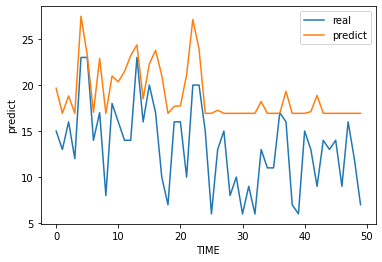

In [ ]:
result = rnn.predict([test_sets[0], test_sets[1], test_sets[2]])
# print(result)
result = scaler.inverse_transform(result)
print(test_sets[3].reshape(-1, 1))
y_test_inver = scaler.inverse_transform(test_sets[3].reshape(-1, 1))
result[result < 0] = 0

print(y_test_inver)
MSE = mean_squared_error(y_test_inver, result) 
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test_inver, result)

print(f'MSE SCORE : {MSE}')
print(f'RMSE SCORE : {RMSE}')
print(f'R2 SCORE : {R2}')

y_test_inver_df = pd.DataFrame(y_test_inver, columns=['Scaled'])
print(y_test_inver_df)
result_df = pd.DataFrame(result, columns=['Scaled'])

result_df.to_csv('./predict.csv')

# plt.figure(figsize=(150,150))
plt.plot(y_test_inver_df, label='real')
plt.plot(result_df, label='predict')
plt.xlabel('TIME')
plt.ylabel('predict')
plt.legend()
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

sample_df = df[df['variant_sku']=='CRUISER-BLACK']
sample_df = sample_df.sort_values(by=['day'])

# 원본데이터의 시작날 ~ 끝나는 날까지 비어있는 dataframe 생성
temp_date_df  = pd.DataFrame(pd.date_range(np.array(sample_df)[0][0], np.array(sample_df)[-1][0]), columns={'day'})
print(temp_date_df)

# 같은 날은 그대로 두고 없는 날짜만 추가.
new_df = pd.merge(sample_df, temp_date_df, how='outer')
print(new_df)

new_df = new_df.sort_values(by=['day'])

dup = np.array(new_df.duplicated(['day']))
new_df_arr = np.array(new_df)

for i in range(len(new_df_arr)):
  if dup[i] == True:
    print('---------------------------------------------------------------------')
    print(f'중복1 : {new_df_arr[i-1]}')
    print(f'중복2 : {new_df_arr[i]}')
    temp = new_df_arr[i][-1]
    new_df_arr[i-1][-1] = new_df_arr[i-1][-1] + temp
    print(f'중복합친후 : {new_df_arr[i-1]}')
    print('---------------------------------------------------------------------')

# 1 == 2 Ture : 2
new_df = pd.DataFrame(new_df_arr, columns=new_df.columns)
new_df.drop_duplicates(['day'], inplace=True)

sample = new_df['net_quantity']
sample.index = new_df['day']
sample = sample.fillna(0)

scaler = StandardScaler()
# scaler.
X_train, X_test, y_train, y_test, y_train_index, y_test_index = split_data(sample, scaler)

            day
0    2019-07-30
1    2019-07-31
2    2019-08-01
3    2019-08-02
4    2019-08-03
...         ...
1159 2022-10-01
1160 2022-10-02
1161 2022-10-03
1162 2022-10-04
1163 2022-10-05

[1164 rows x 1 columns]
            day    variant_sku product_vendor  product_price  net_quantity
0    2019-07-30  CRUISER-BLACK          EMOVE         1399.0           1.0
1    2019-08-03  CRUISER-BLACK          EMOVE         1399.0           1.0
2    2019-08-04  CRUISER-BLACK          EMOVE         1399.0           1.0
3    2019-08-06  CRUISER-BLACK          EMOVE         1399.0           1.0
4    2019-08-07  CRUISER-BLACK          EMOVE         1399.0           1.0
...         ...            ...            ...            ...           ...
1168 2022-09-26            NaN            NaN            NaN           NaN
1169 2022-09-28            NaN            NaN            NaN           NaN
1170 2022-10-01            NaN            NaN            NaN           NaN
1171 2022-10-02            NaN   

In [ ]:
X_train_t = X_train.reshape(X_train.shape[0], 7, 1)
X_test_t = X_test.reshape(X_test.shape[0], 7, 1)

# print(X_test_t)
print("최종 DATA")
print(X_train_t.shape)

# [[[1], [2], [3], [4], [5], [6], [7]]]

최종 DATA
(1107, 7, 1)


In [ ]:
# //Tensorflow//
import keras.backend as K

K.clear_session()
model = Sequential()

# units = 50 --> 25 50 100 150 실험적으로 찾아야되는 부분
model.add(LSTM(units = 100, return_sequences = True, input_shape = (7, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

# 마지막은 return_seqences = False
model.add(LSTM(units = 100))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

print(model.summary())
# model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [ ]:
"""

각 스쿠터 class 별로 전부 학습 --> 스쿠터가 N개  스쿠터이름_Model N개.

특정 스쿠터가 들어왔을때 그 스쿠터에 대한 학습이루어진 Model weight를 load해와서 test를 진행.

"""

'\n\n각 스쿠터 class 별로 전부 학습 --> 스쿠터가 N개  스쿠터이름_Model N개.\n\n특정 스쿠터가 들어왔을때 그 스쿠터에 대한 학습이루어진 Model weight를 load해와서 test를 진행.\n\n'

In [ ]:
from tensorflow.python.eager.context import monitoring

model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
# batch_size = 1 : 7
# batch_size = 20 : 7 * 20 --> 140 
# 1 2 4 8 16 32 64 128 256 512
model.fit(X_train_t, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
35/35 [==============================] - 7s 25ms/step - loss: 0.0951
Epoch 2/100
35/35 [==============================] - 1s 25ms/step - loss: 0.0854
Epoch 3/100
35/35 [==============================] - 1s 25ms/step - loss: 0.0962
Epoch 4/100
35/35 [==============================] - 1s 26ms/step - loss: 0.1002
Epoch 5/100
35/35 [==============================] - 1s 26ms/step - loss: 0.0956
Epoch 6/100
35/35 [==============================] - 1s 26ms/step - loss: 0.0933
Epoch 7/100
35/35 [==============================] - 1s 25ms/step - loss: 0.0866
Epoch 8/100
35/35 [==============================] - 1s 25ms/step - loss: 0.0789
Epoch 9/100
35/35 [==============================] - 1s 25ms/step - loss: 0.0802
Epoch 10/100
35/35 [==============================] - 1s 25ms/step - loss: 0.0787
Epoch 11/100
35/35 [==============================] - 1s 27ms/step - loss: 0.0862
Epoch 12/100
35/35 [==============================] - 1s 26ms/step - loss: 0.0792
Epoch 13/100
35/35 [=====

2/2 [==============================] - 0s 11ms/step
MSE SCORE : 7.847428542768363
RMSE SCORE : 2.801326211416365
R2 SCORE : -0.4258938065623725
            Scaled
day               
2022-08-24     7.0
2022-08-25     0.0
2022-08-26     5.0
2022-08-27     2.0
2022-08-28     3.0
2022-08-29     7.0
2022-08-30     7.0
2022-08-31     0.0
2022-09-01     0.0
2022-09-02     0.0
2022-09-03     7.0
2022-09-04     4.0
2022-09-05     2.0
2022-09-06     3.0
2022-09-07     3.0
2022-09-08     4.0
2022-09-09     5.0
2022-09-10     3.0
2022-09-11     3.0
2022-09-12     0.0
2022-09-13     4.0
2022-09-14     5.0
2022-09-15     0.0
2022-09-16     0.0
2022-09-17     3.0
2022-09-18     3.0
2022-09-19     0.0
2022-09-20     3.0
2022-09-21     0.0
2022-09-22     7.0
2022-09-23     5.0
2022-09-24     2.0
2022-09-25     5.0
2022-09-26     0.0
2022-09-27     5.0
2022-09-28     0.0
2022-09-29     4.0
2022-09-30     2.0
2022-10-01     0.0
2022-10-02     0.0
2022-10-03     2.0
2022-10-04     0.0
2022-10-05     2.0


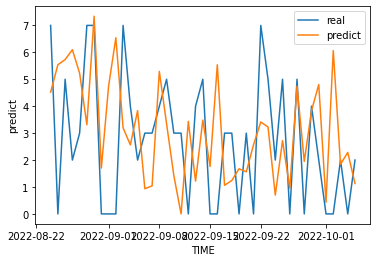

In [ ]:
# print(y_pred_inver[:5])
y_pred = model.predict(X_test_t)

y_test_inver = scaler.inverse_transform(y_test)
y_pred_inver = scaler.inverse_transform(y_pred)
y_pred_inver[y_pred_inver < 0] = 0

MSE = mean_squared_error(y_test_inver, y_pred_inver) 
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test_inver, y_pred_inver)

print(f'MSE SCORE : {MSE}')
print(f'RMSE SCORE : {RMSE}')
print(f'R2 SCORE : {R2}')

y_test_inver_df = pd.DataFrame(y_test_inver, columns=['Scaled'], index=y_test_index.index)
print(y_test_inver_df)
y_pred_inver_df = pd.DataFrame(y_pred_inver, columns=['Scaled'], index=y_test_index.index)

y_pred_inver_df.to_csv('./predict.csv')

# plt.figure(figsize=(150,150))
plt.plot(y_test_inver_df, label='real')
plt.plot(y_pred_inver_df, label='predict')
plt.xlabel('TIME')
plt.ylabel('predict')
plt.legend()
plt.show()

# 50일 평균 1.6개  2개
# 7주일 : 7일 예측을 전부 따로 한것 --> 합 : 7일 평균
# -2개 == 2개를 많이
# -2개 +2개 // 2개

35/35 [==============================] - 0s 8ms/step
MSE SCORE : 0.20890828690064153
RMSE SCORE : 0.4570648607152398
R2 SCORE : 0.9625835781015818


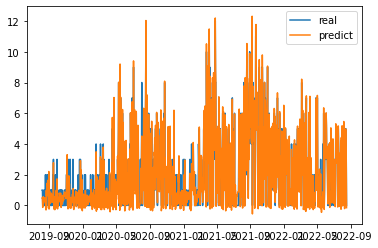

In [ ]:
y_pred_train_data = model.predict(X_train_t)

y_origin_train_data_inver = scaler.inverse_transform(y_train)
y_pred_train_data_inver = scaler.inverse_transform(y_pred_train_data)
y_origin_train_data_inver[y_origin_train_data_inver < 0] = 0
# print(y_pred_inver[:5])

MSE = mean_squared_error(y_origin_train_data_inver, y_pred_train_data_inver) 
RMSE = np.sqrt(MSE)
R2 = r2_score(y_origin_train_data_inver, y_pred_train_data_inver)

print(f'MSE SCORE : {MSE}')
print(f'RMSE SCORE : {RMSE}')
print(f'R2 SCORE : {R2}')

y_origin_train_data_inver = pd.DataFrame(y_origin_train_data_inver, columns=['Scaled'], index=y_train_index.index)
y_pred_train_data_inver = pd.DataFrame(y_pred_train_data_inver, columns=['Scaled'], index=y_train_index.index)

plt.plot(y_origin_train_data_inver, label='real')
plt.plot(y_pred_train_data_inver, label='predict')
plt.legend()
plt.show()

          day  Scale
0  2022-10-05    2.0
1  2022-10-06    NaN
2  2022-10-07    NaN
3  2022-10-08    NaN
4  2022-10-09    NaN
..        ...    ...
83 2022-12-27    NaN
84 2022-12-28    NaN
85 2022-12-29    NaN
86 2022-12-30    NaN
87 2022-12-31    NaN

[88 rows x 2 columns]
[-0.91296101 -0.06542887 -0.91296101 -0.91296101 -0.06542887  0.78210327
 -0.91296101]
1/1 [==============================] - 0s 20ms/step
               Scale
0                   
2022-10-05       2.0
2022-10-06  2.098999
2022-10-07  2.720714
2022-10-08  1.708051
2022-10-09  0.142275
...              ...
2022-12-27  0.643046
2022-12-28    0.6577
2022-12-29   0.69104
2022-12-30  0.705761
2022-12-31  0.727921

[88 rows x 1 columns]


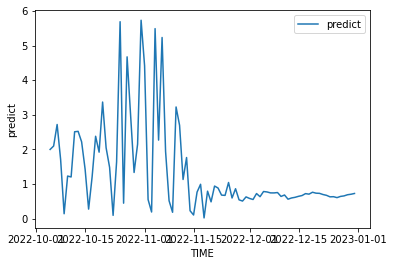

In [ ]:
predict_df = pd.read_csv('./temp.csv')
temp = X_test[-1]
#X_test[-1] --> 10/5 predict
#X_test[-1] --> 10/5일 이전 일주일데이터를 
#[1 ,2 ,3 ,4 ,5 ,6 ,7]  10/5 [10]
#[10, 1, 2, 3, 4, 5, 6] ==> 10월 6일 predict를 위한 7일 데이터
#[[1] [2] [3] [4]]
predict_arr = np.array(predict_df)

dummy_predict_df = pd.DataFrame(pd.date_range(np.array(predict_df)[-1][0], '2022-12-31'), columns={'day'})
dummy_predict_df["Scale"] = np.nan
dummy_predict_df.loc[0, 'Scale'] = predict_arr[-1][1]
print(dummy_predict_df)

# a = np.array([[predict_arr[-1][1]]])
# insert_value = scaler.transform(a)
# temp = np.append(temp, insert_value)
# temp = np.roll(temp, shift=-1)
# temp = np.delete(temp, -1)

dummy_predict_arr = np.array(dummy_predict_df)
previous_test_x = X_test[-1]
print(previous_test_x)


for i in range(len(dummy_predict_arr)-1):
  previous_predict_val = dummy_predict_arr[i][1]
  previous_predict_val = np.array([[previous_predict_val]])
  insert_value = scaler.transform(previous_predict_val)

  test_x = previous_test_x
  # [1 2 3 4 5 6 7]
  test_x = np.append(test_x, insert_value)
  # [1 2 3 4 5 6 7 10]
  test_x = np.roll(test_x, shift=-1)
  # [10 1 2 3 4 5 6 7]
  test_x = np.delete(test_x, -1)
  # [10 1 2 3 4 5 6]
  test_x_t = test_x.reshape(1, 7, 1)
  # [[10] [1] [2] [3] [4] [5] [6]]

  predict_val = model.predict(test_x_t)

  dummy_predict_arr[i+1][1] = scaler.inverse_transform(predict_val)[0][0]
  previous_test_x = test_x

dummy_predict_df = pd.DataFrame(dummy_predict_arr, index=dummy_predict_df.index)
result = dummy_predict_df[1]
result = np.array(result)
result[result < 0] = 0
result = pd.DataFrame(result, columns={'Scale'})
result.index = dummy_predict_df[0]
# result = dummy_predict_df['1']
print(result)

plt.plot(result, label='predict')
plt.xlabel('TIME')
plt.ylabel('predict')
plt.legend()
plt.show()


[['2022-08-24' 4.521715]
 ['2022-08-25' 5.5396833]
 ['2022-08-26' 5.731932]
 ['2022-08-27' 6.098015]
 ['2022-08-28' 5.226783]
 ['2022-08-29' 3.3132417]
 ['2022-08-30' 7.3402157]
 ['2022-08-31' 1.7028166]
 ['2022-09-01' 4.7482557]
 ['2022-09-02' 6.5418005]
 ['2022-09-03' 3.195814]
 ['2022-09-04' 2.5634549]
 ['2022-09-05' 3.833959]
 ['2022-09-06' 0.9355718]
 ['2022-09-07' 1.0415777]
 ['2022-09-08' 5.293239]
 ['2022-09-09' 3.3480043]
 ['2022-09-10' 1.4252524]
 ['2022-09-11' 0.0]
 ['2022-09-12' 3.4350853]
 ['2022-09-13' 1.2186333]
 ['2022-09-14' 3.4838638]
 ['2022-09-15' 1.7597834]
 ['2022-09-16' 5.5376773]
 ['2022-09-17' 1.0625974]
 ['2022-09-18' 1.2394296]
 ['2022-09-19' 1.6763067]
 ['2022-09-20' 1.5627997]
 ['2022-09-21' 2.5705042]
 ['2022-09-22' 3.4133353]
 ['2022-09-23' 3.225796]
 ['2022-09-24' 0.6992147]
 ['2022-09-25' 2.719168]
 ['2022-09-26' 0.9573084]
 ['2022-09-27' 4.7440815]
 ['2022-09-28' 1.9499373]
 ['2022-09-29' 3.834335]
 ['2022-09-30' 4.806288]
 ['2022-10-01' 0.42865264]
 [

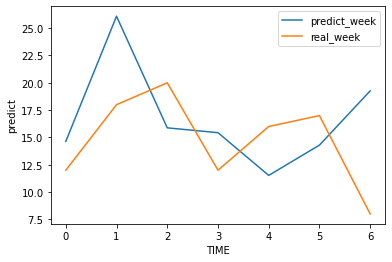

In [ ]:
predict_df = pd.read_csv('./predict.csv')
arr = np.array(predict_df)
y_test_inver_arr = np.array(y_test_inver_df)
print(arr)
print(y_test_inver_arr)
# arr = np.delete(arr, 0)
# arr = np.delete(arr, 0)
# arr = np.delete(arr, 0)
# print(arr)

week_list = []
week_real_list = []
temp = 0
sum = 0
sum_real = 0
for i in range(len(arr)):
  if i <= 2 :
    pass

  else:
      sum = arr[i][1] + sum
      sum_real = y_test_inver_arr[i] + sum_real
  temp += 1
  if temp == 6:
    week_list.append(sum)
    week_real_list.append(sum_real)
    temp = 0
    sum = 0
    sum_real = 0


print(week_list)
print(week_real_list)


plt.plot(week_list, label='predict_week')
plt.plot(week_real_list, label='real_week')
plt.xlabel('TIME')
plt.ylabel('predict')
plt.legend()
plt.show()

# 한달 / 2주 --> 새로운 데이터가 쌓이고 예측해야되는 날짜가 한달정도 뒤가 될때